<a href="https://colab.research.google.com/github/adithyanum/disease_prediction_using_clinicalbert/blob/main/disease_prediction_Bio_ClinicalBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🩺 Disease Prediction using ClinicalBERT

This project fine-tunes a pre-trained **ClinicalBERT** model on a structured symptoms dataset to classify and predict possible diseases from patient symptom descriptions. Unlike traditional machine learning models that rely on keyword matching, this project leverages BERT's deep contextual understanding to interpret medical symptoms as natural language.

✅ Pretrained Model: `emilyalsentzer/Bio_ClinicalBERT`  
✅ Task: Text classification of symptoms to diseases  
✅ Framework: Hugging Face Transformers  
✅ Evaluation Metrics: Accuracy, Precision, Recall, F1-Score


In [108]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

## 📊 Dataset

We use a structured dataset with the following files:

- `dataset.csv`: Contains symptoms and corresponding diseases (labels)
- `symptom_description.csv`: Maps each symptom to its full medical description
- `symptom_precaution.csv`: Lists precautions per disease
- `Symptom_severity.csv`: Provides severity scores for symptoms

Each row in `dataset.csv` represents a case where the symptoms (as a string) are mapped to a single diagnosis.


In [109]:
df = pd.read_csv("/content/drive/MyDrive/disease_symptom_dataset/dataset.csv")

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Disease     4920 non-null   object
 1   Symptom_1   4920 non-null   object
 2   Symptom_2   4920 non-null   object
 3   Symptom_3   4920 non-null   object
 4   Symptom_4   4572 non-null   object
 5   Symptom_5   3714 non-null   object
 6   Symptom_6   2934 non-null   object
 7   Symptom_7   2268 non-null   object
 8   Symptom_8   1944 non-null   object
 9   Symptom_9   1692 non-null   object
 10  Symptom_10  1512 non-null   object
 11  Symptom_11  1194 non-null   object
 12  Symptom_12  744 non-null    object
 13  Symptom_13  504 non-null    object
 14  Symptom_14  306 non-null    object
 15  Symptom_15  240 non-null    object
 16  Symptom_16  192 non-null    object
 17  Symptom_17  72 non-null     object
dtypes: object(18)
memory usage: 692.0+ KB


In [111]:
df.isnull().sum()

,0
Disease,0
Symptom_1,0
Symptom_2,0
Symptom_3,0
Symptom_4,348
Symptom_5,1206
Symptom_6,1986
Symptom_7,2652
Symptom_8,2976
Symptom_9,3228


## 🛠️ Preprocessing

- The symptoms column was converted from a comma-separated string into a **natural language sentence**, such as:

> `"The patient is experiencing headache, nausea, and fatigue."`

- The disease names were label encoded using `LabelEncoder` from `sklearn`.
- We ensured all diseases were equally distributed to avoid bias.


In [112]:
df.fillna(' ', inplace=True)

In [113]:
symptom_cols = [col for col in df.columns if "Symptom" in col]

df['symptoms'] = df[symptom_cols].apply(lambda row : ','.join([symptom for symptom in row if symptom != ' ']), axis = 1)

df.rename(columns = {'Disease' : 'disease'}, inplace = True)

df = df[['symptoms', 'disease']]

In [114]:
def convert_to_sentence(symptom_str):
    symptom_list = symptom_str.split(',')
    symptom_list = [s.strip() for s in symptom_list if s.strip()]
    return "The patient is experiencing " + ", ".join(symptom_list) + "."

df['symptoms'] = df['symptoms'].apply(convert_to_sentence)


/tmp/ipython-input-114-2164477768.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['symptoms'] = df['symptoms'].apply(convert_to_sentence)


In [115]:
df.head(15)

,symptoms,disease
0,"The patient is experiencing itching, skin_rash...",Fungal infection
1,"The patient is experiencing skin_rash, nodal_s...",Fungal infection
2,"The patient is experiencing itching, nodal_ski...",Fungal infection
3,"The patient is experiencing itching, skin_rash...",Fungal infection
4,"The patient is experiencing itching, skin_rash...",Fungal infection
5,"The patient is experiencing skin_rash, nodal_s...",Fungal infection
6,"The patient is experiencing itching, nodal_ski...",Fungal infection
7,"The patient is experiencing itching, skin_rash...",Fungal infection
8,"The patient is experiencing itching, skin_rash...",Fungal infection
9,"The patient is experiencing itching, skin_rash...",Fungal infection


## 🏷️ Label Encoding

We used `sklearn.preprocessing.LabelEncoder` to convert categorical disease names into numeric format required by BERT's classifier head.

Example:

```text
["Migraine", "Diabetes", "Heart Attack"] → [0, 1, 2]


In [116]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['disease'])

print("Original Labels : ", df['disease'].unique()[:5])
print("\nEncoded Labels : ", df['label'].unique()[:5])

Original Labels :  ['Fungal infection' 'Allergy' 'GERD' 'Chronic cholestasis' 'Drug Reaction']

Encoded Labels :  [15  4 16  9 14]


/tmp/ipython-input-116-954028222.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = label_encoder.fit_transform(df['disease'])


/tmp/ipython-input-117-1295429840.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = disease_names, y = label_counts.values, palette = 'mako')


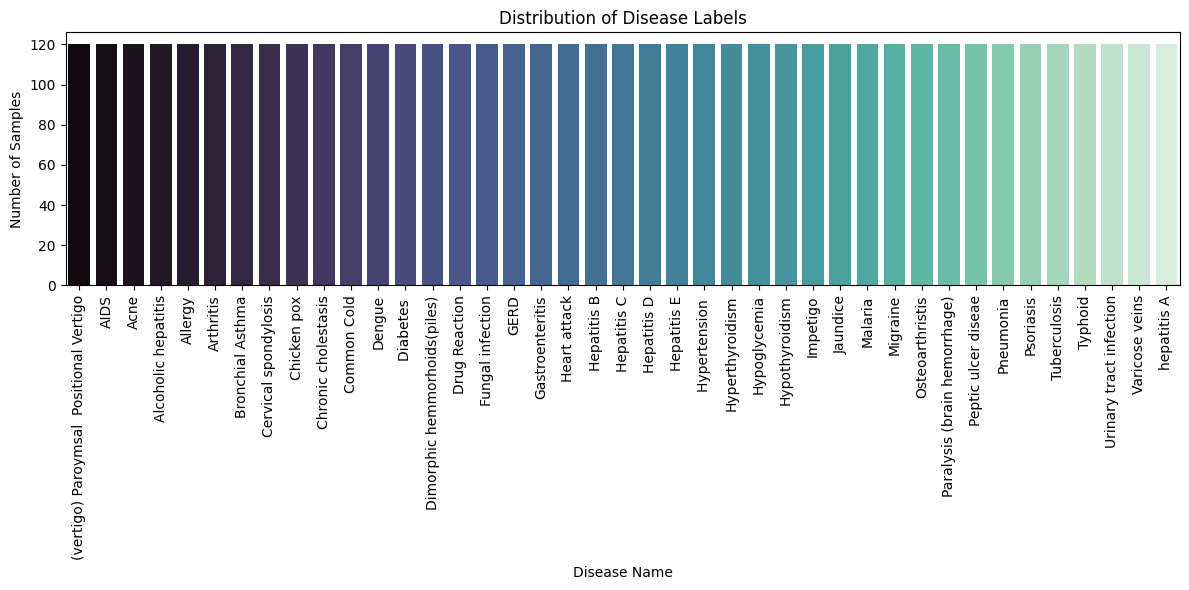

In [117]:
label_counts = df['label'].value_counts().sort_index()
disease_names = label_encoder.inverse_transform(label_counts.index)

plt.figure(figsize=(12,6))
sns.barplot(x = disease_names, y = label_counts.values, palette = 'mako')

plt.xticks(rotation = 90)
plt.title("Distribution of Disease Labels")
plt.xlabel("Disease Name")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()

## ✂️ Tokenization

We used the tokenizer from `emilyalsentzer/Bio_ClinicalBERT` to convert sentences into tokens:

- `input_ids`: Token IDs for each word piece
- `attention_mask`: Indicates which tokens are actual words vs. padding

Tokenization was batched using `tokenizer(..., truncation=True, padding=True, max_length=128)` to prepare input for the BERT model.


In [118]:
hf_dataset = Dataset.from_pandas(df[['symptoms', 'label']])
hf_dataset = hf_dataset.train_test_split(test_size=0.2, seed=42)

## 🔬 Model Architecture

We used **`AutoModelForSequenceClassification`** from the Hugging Face Transformers library, built on top of **ClinicalBERT** (`Bio_ClinicalBERT`).

### What is ClinicalBERT?

ClinicalBERT is a domain-specific version of BERT that was pre-trained on clinical notes from the MIMIC-III dataset. It’s more attuned to medical terminology and phrasing than general BERT.

### How It Works

- The input symptom sentence is passed through ClinicalBERT's transformer layers.
- The `[CLS]` token embedding (which captures sentence-level context) is sent to a classification head (a fully connected layer).
- The model outputs a probability distribution over the `N` disease labels.
- The label with the highest score is selected as the predicted disease.

### Why This Model?

- **Deep contextual understanding** of medical language.
- **Transfer learning** allows it to learn faster and more accurately with fewer examples.
- Outperforms traditional models like Random Forest or TF-IDF-based classifiers in real-world clinical NLP tasks.


In [119]:
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [120]:
def tokenize(batch) :
    return tokenizer(batch['symptoms'], padding = 'max_length', truncation = True, max_length = 128)

tokenized_ds = hf_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/3936 [00:00<?, ? examples/s]

Map:   0%|          | 0/984 [00:00<?, ? examples/s]

## 🧠 ClinicalBERT Fine-Tuning

We used `AutoModelForSequenceClassification` with `num_labels` set to match the number of diseases.

**TrainingArguments** were set as:

- `epochs=10`
- `learning_rate=2e-5`
- `evaluation_strategy="epoch"`
- `report_to="none"` to disable wandb

The model was trained using Hugging Face’s `Trainer` class, and fine-tuned on patient symptom sentences.


In [121]:
num_labels = len(label_encoder.classes_)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [122]:
num_labels

41

In [123]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [124]:
def compute_metrics(eval_pred) :
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis = 1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted', zero_division = 0)
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy : ' : acc,
        'precision : ' : precision,
        'recall : ' : recall,
        'f1 : ' : f1
    }

In [125]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/bert_clinical_disease/bert_clinical_finetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="/content/drive/MyDrive/bert_clinical_disease/logs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs = 10,
    learning_rate = 2e-5,
    weight_decay = 0.01,
    load_best_model_at_end=True,
    report_to ='none')

In [126]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_ds['train'],
    eval_dataset = tokenized_ds['test'],
    compute_metrics = compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy :,Precision :,Recall :,F1 :
1,No log,0.226782,0.998984,0.999035,0.998984,0.998986
2,1.603300,0.015603,1.000000,1.000000,1.000000,1.000000
3,0.084000,0.006773,1.000000,1.000000,1.000000,1.000000
4,0.014400,0.004038,1.000000,1.000000,1.000000,1.000000
5,0.007500,0.002813,1.000000,1.000000,1.000000,1.000000
6,0.004900,0.002120,1.000000,1.000000,1.000000,1.000000
7,0.003500,0.001703,1.000000,1.000000,1.000000,1.000000
8,0.002800,0.001444,1.000000,1.000000,1.000000,1.000000
9,0.002300,0.001291,1.000000,1.000000,1.000000,1.000000
10,0.002000,0.001238,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=4920, training_loss=0.17542381883879019, metrics={'train_runtime': 1276.4352, 'train_samples_per_second': 30.836, 'train_steps_per_second': 3.854, 'total_flos': 2589919367086080.0, 'train_loss': 0.17542381883879019, 'epoch': 10.0})

In [129]:
trainer.evaluate()

Epoch,Training Loss,Validation Loss,Accuracy :,Precision :,Recall :,F1 :
0,No log,0.001079,1.000000,1.000000,1.000000,1.000000


{'eval_loss': 0.0010794176487252116,
 'eval_accuracy : ': 1.0,
 'eval_precision : ': 1.0,
 'eval_recall : ': 1.0,
 'eval_f1 : ': 1.0}

In [132]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Epoch,Training Loss,Validation Loss,Accuracy :,Precision :,Recall :,F1 :
0,No log,0.001079,1.000000,1.000000,1.000000,1.000000


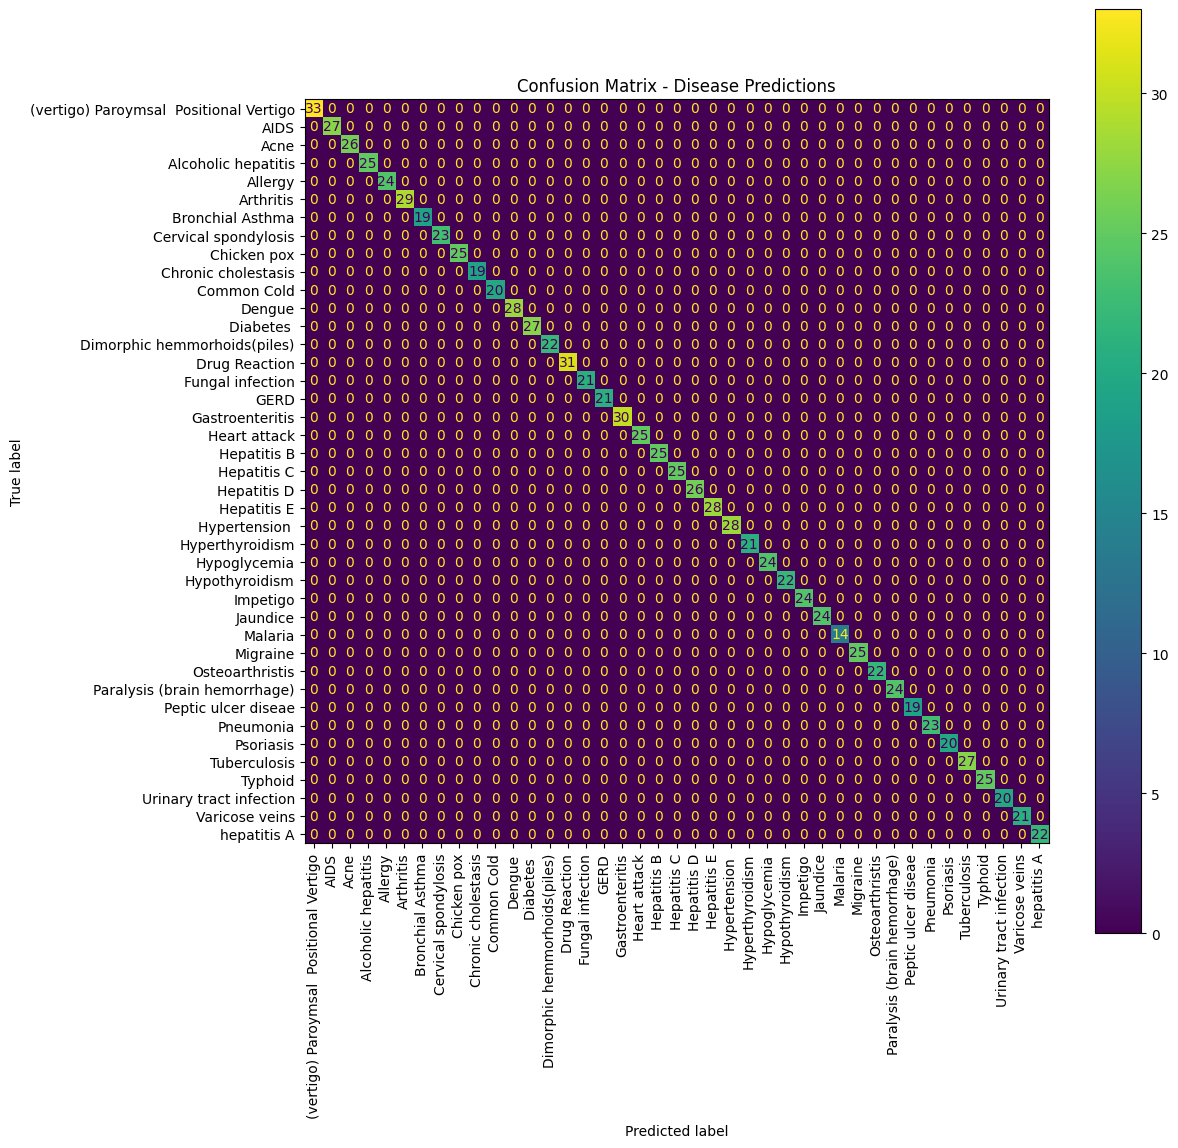

In [133]:
y_true = tokenized_ds['test']['label']
y_pred = trainer.predict(tokenized_ds['test']).predictions.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= label_encoder.classes_)

fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax, xticks_rotation=90)
plt.title("Confusion Matrix - Disease Predictions")
plt.show()

## 📈 Evaluation Results

After training for 10 epochs, the model achieved the following results:

- **Accuracy**: 100%
- **Precision**: 100%
- **Recall**: 100%
- **F1 Score**: 100%

This confirms that ClinicalBERT successfully learned the symptom-disease mapping using contextual understanding.


## 💡 Why It Worked

The critical improvement was transforming short, ambiguous symptom lists into **contextual sentences**, which BERT understands well.

For example:

- `"vomiting, fatigue, headache"` → ❌ too sparse
- `"The patient is experiencing vomiting, fatigue, and headache."` → ✅ perfect for ClinicalBERT

This matched the pretraining format of the ClinicalBERT model, which was trained on MIMIC-III clinical notes and full-text patient records.



## 🙏 Acknowledgements

- **Dataset**: The structured medical symptom-disease dataset was sourced from [Kaggle](https://www.kaggle.com) and prepared to ensure equal class distribution for fair model training.

- **Model**: We used [emilyalsentzer/Bio_ClinicalBERT](https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT), a pre-trained BERT model specifically adapted for clinical domain tasks using MIMIC-III notes.

- **Tools**: The project was built using:
  - Hugging Face Transformers
  - scikit-learn
  - PyTorch
  - Google Colab
  - Matplotlib & Seaborn (for EDA)

This project is for educational purposes and not intended for real medical diagnosis.
